In [1]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
set.seed(1)
load_all("../../../hmmTMB")
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

plot_folder <- "tsx_only_plots"

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', ex

[1] 14

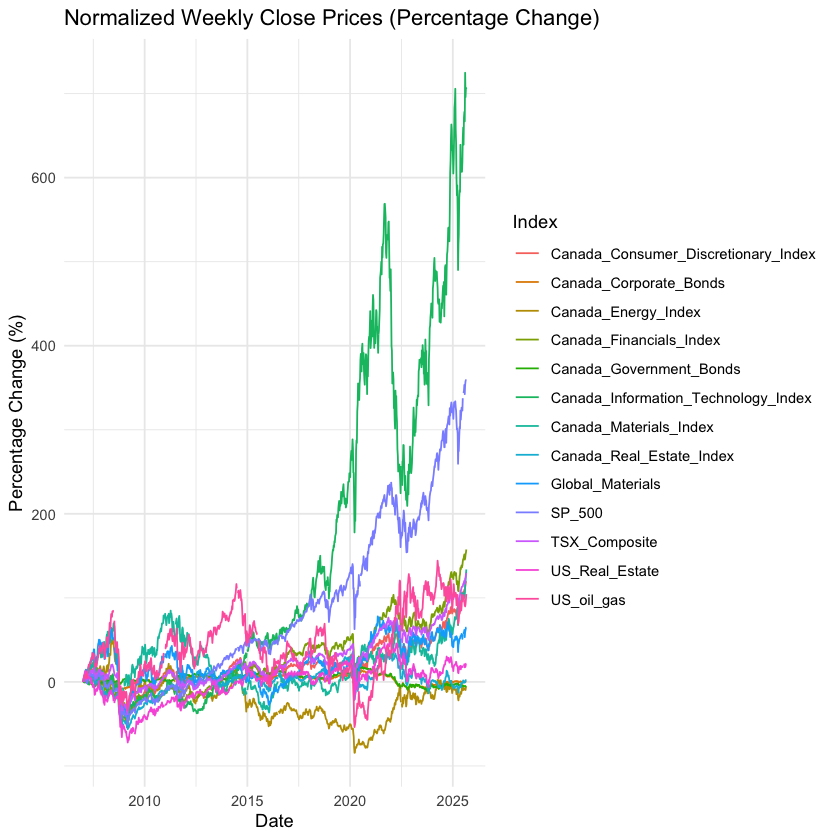

In [2]:

close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks")

# Reshape data for ggplot
close_data_long <- close_data %>%
  mutate(Date = rownames(close_data)) %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100) %>%  # Normalize as percentage change
  mutate(Date = as.Date(Date))

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()

ncol(close_data)

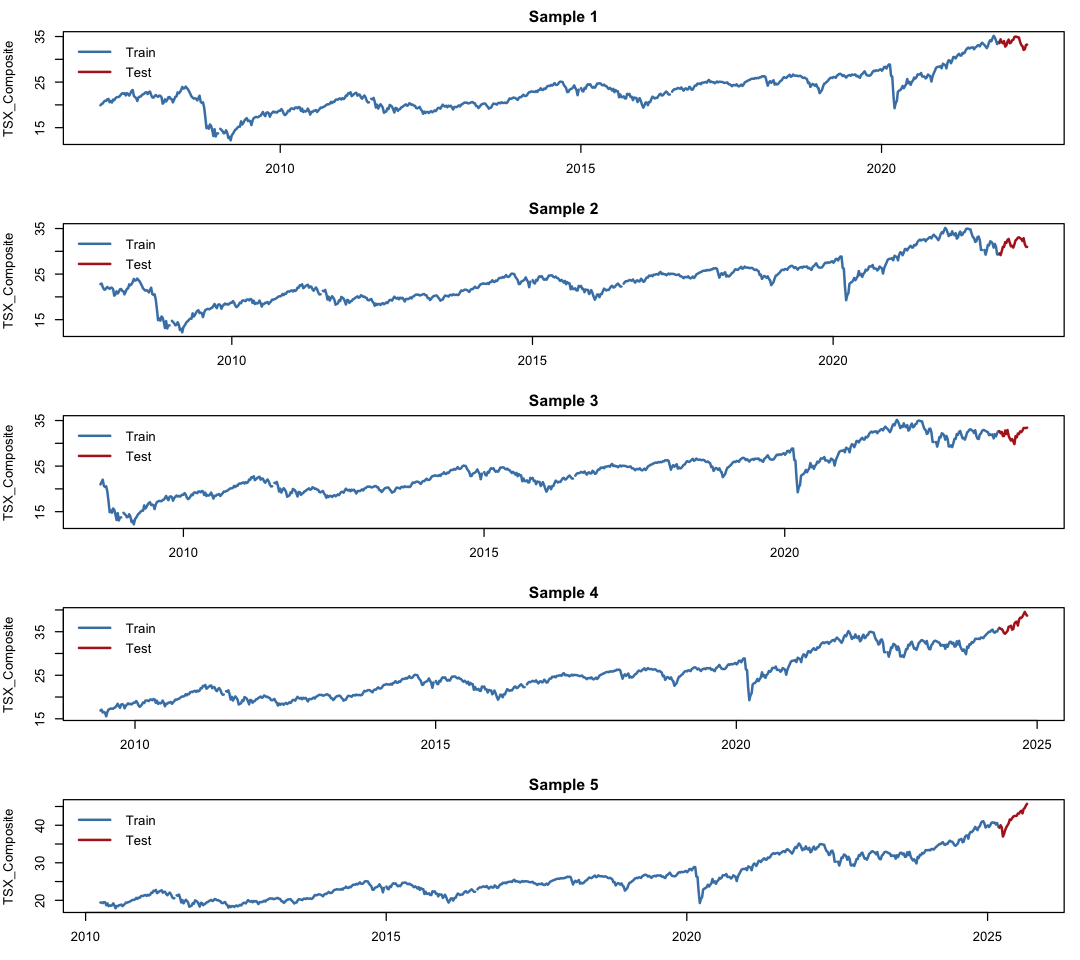

In [3]:
splits <- train_test_split(
  close_data,
  training_period_w = 780,
  testing_period_w = 25,
  samples = 5
)

options(repr.plot.width = 9, repr.plot.height = 8)  # Adjust figure size

plot_train_test_samples(splits,
  y_column = "TSX_Composite",
  savefig = paste0(plot_folder, "/train_test_split_TSX_Composite.png"))
plot_train_test_samples(splits,
  y_column = "TSX_Composite")

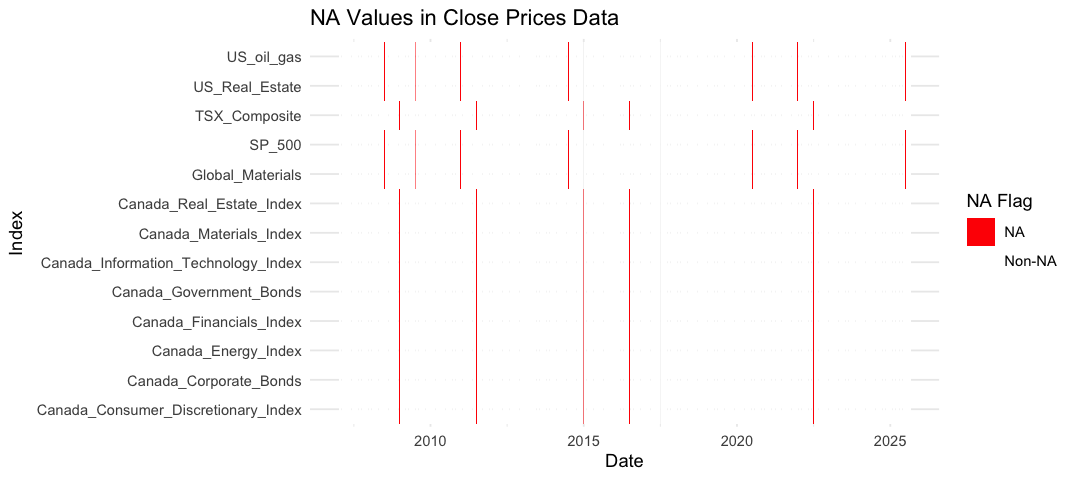

In [4]:
options(repr.plot.width = 9, repr.plot.height = 4)  # Adjust figure size
plot_na_matrix(close_data, title = "NA Values in Close Prices Data")

# Simple model for TSX only

In [5]:
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

splits <- train_test_split(
  close_data,
  training_period_w = 780,
  testing_period_w = 16,
  samples = 5
)

sample_id <- 1
observation <- "TSX_Composite"

train_data_log_list <- sapply(splits$train, ln_transform, simplify = FALSE)
test_data_log_list <- mapply(ln_transform, splits$test,
                             previous_row = lapply(splits$train, tail, 1),
                             SIMPLIFY = FALSE)

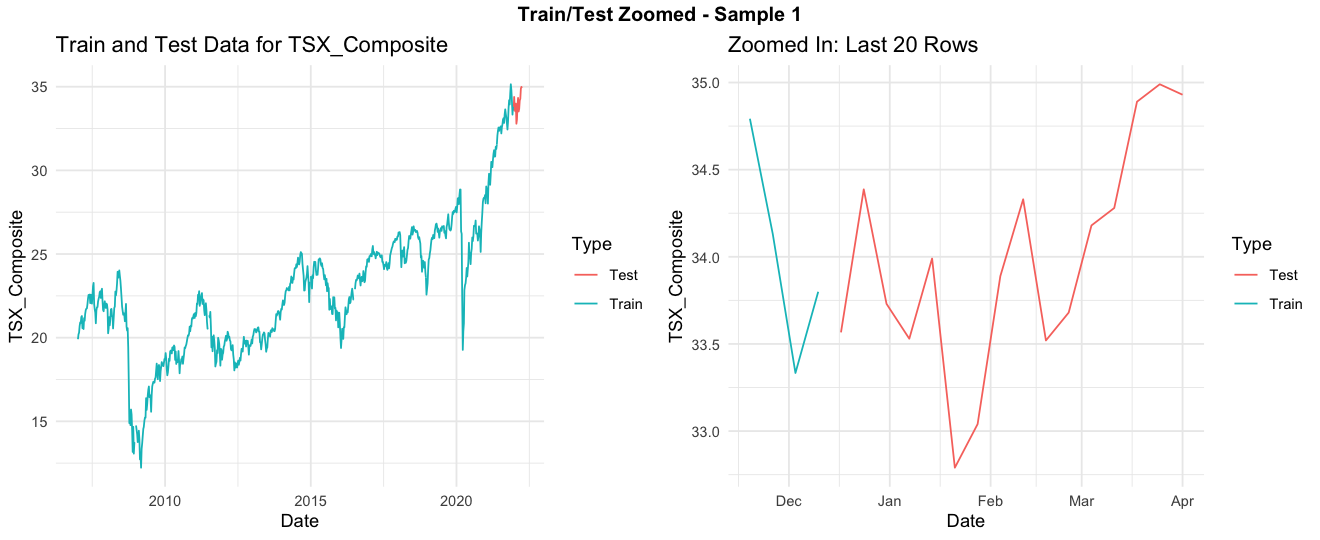

In [6]:
options(repr.plot.width = 11, repr.plot.height = 4.5)  # Adjust figure size
plot_train_test_zoomed(
  splits$train[[sample_id]],
  splits$test[[sample_id]],
  observation = "TSX_Composite",
  zoom_range = 20,
  title = paste0("Train/Test Zoomed - Sample ", sample_id),
  savefig = paste0(plot_folder, "/train_test_zoomed_TSX_Composite_sample_", sample_id, ".png")
)

In [7]:
optimal_n <- data.frame(
  n_states = integer(),
  AIC = numeric()
)
for (n in 2:6) {
  hmm <- fit_markets_hmm(n_states = n, data = train_data_log_list[[sample_id]])
  optimal_n <- rbind(optimal_n, data.frame(n_states = n, AIC = hmm$AIC_conditional()))
}


Warning message in sqrt(diag(object$cov.fixed)):
“NaNs produced”
Warning message in sqrt(diag(object$cov.fixed)):
“NaNs produced”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”


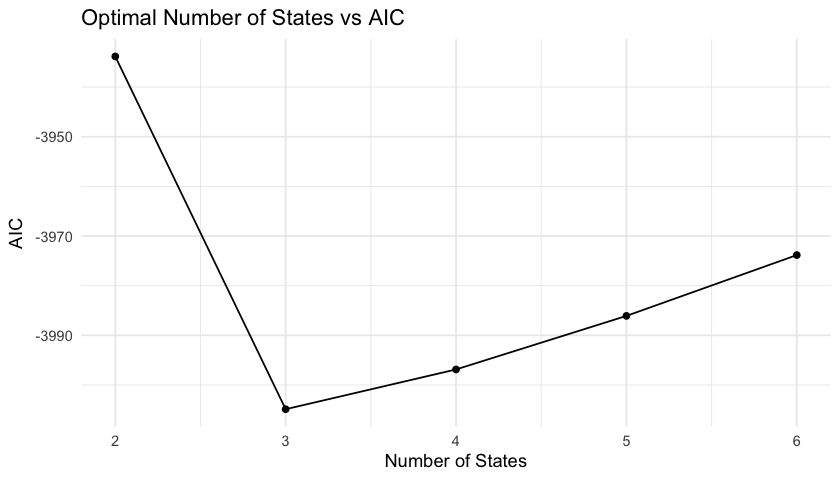

In [8]:
options(repr.plot.width = 7, repr.plot.height = 4)  # Adjust figure size
ggplot(optimal_n, aes(x = n_states, y = AIC)) +
  geom_line() +
  geom_point() +
  labs(title = "Optimal Number of States vs AIC", x = "Number of States", y = "AIC") +
  theme_minimal()

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


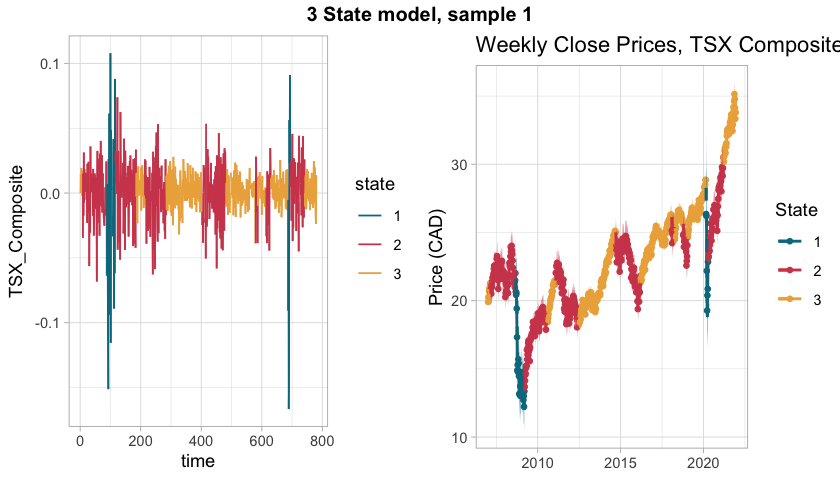

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


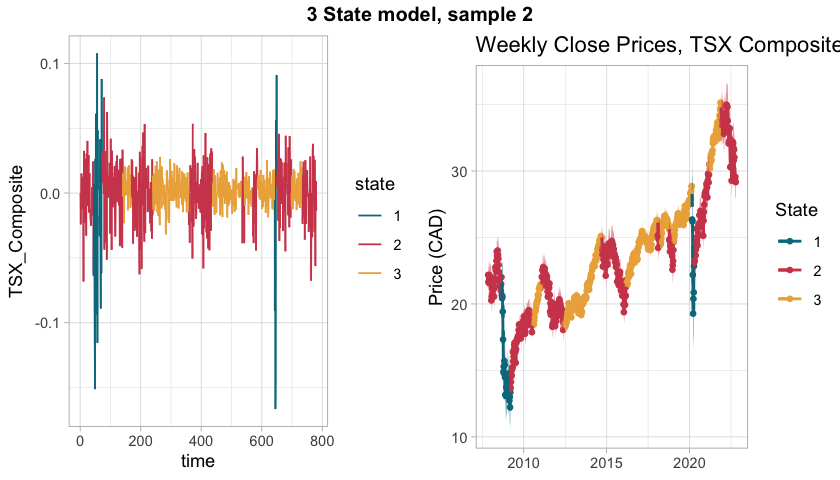

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


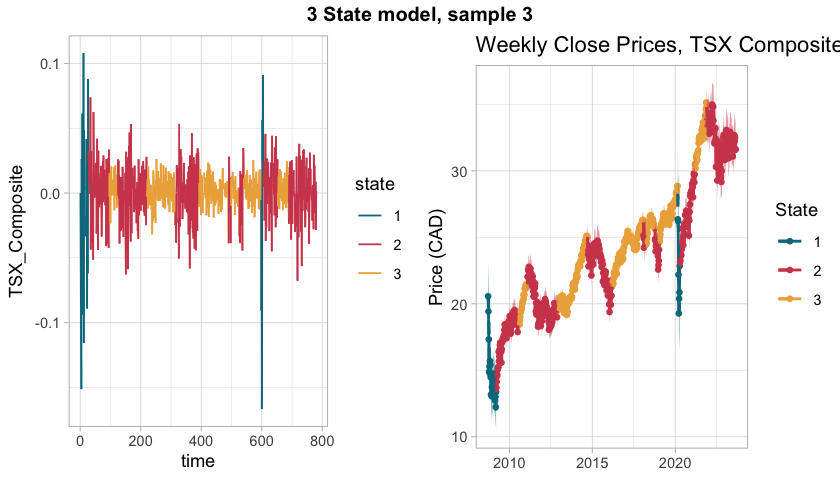

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_ribbon()`).”


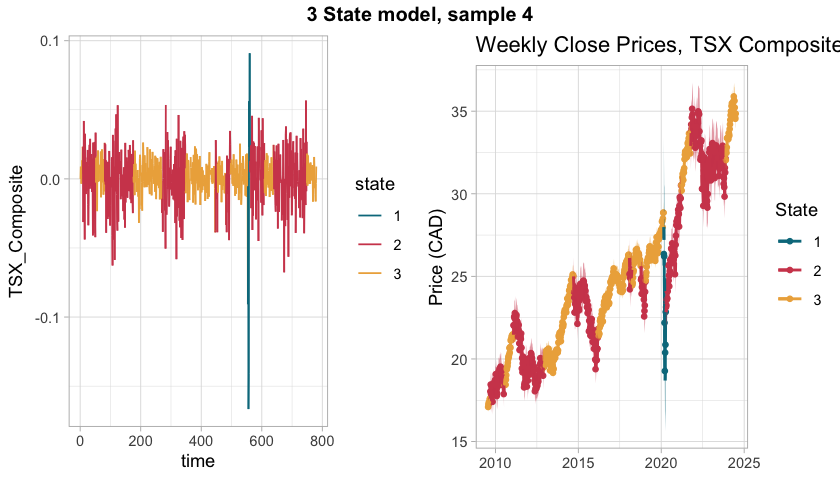

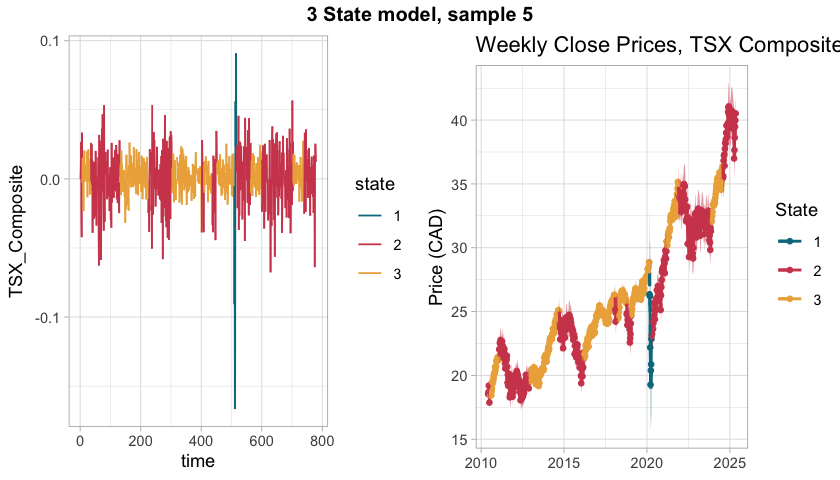

In [10]:
hmms <- lapply(1:length(splits$train), function(n) {
  fit_markets_hmm(n_states = 3, data = train_data_log_list[[n]])
})

for (i in 1:length(hmms)) {
  hmm <- hmms[[i]]

  plot_tsx_state_overview(
    hmm         = hmm,             # fitted HMM object
    train_data  = splits$train[[i]],      # data used to fit the model (needs Date + TSX_Composite)
    observation = "TSX_Composite", # defaults to this, change if you need another series
    show        = "both",          # options: "both", "states", "interval"
    title       = paste0("3 State model, sample ", i),  # optional heading
    savefig     = paste0(plot_folder, "/tsx_state_overview_sample_", i, ".png")
  )
}

In [11]:
hmms[[1]]$print_obspar()

> Estimated observation parameters (t = 1):
                   state 1 state 2 state 3
TSX_Composite.mean  -0.020   0.000   0.003
TSX_Composite.sd     0.069   0.023   0.010



In [13]:
forecast_range <- nrow(splits$test[[1]])

forecasts <- lapply(1:length(splits$train), function(n) {
  hmm <- hmms[[n]]
  forecast <- hmmTMB::Forecast$new(
    hmm,
    n = forecast_range,
    preset_eval_range = list(TSX_Composite=seq(-0.15, 0.15, by = 0.01))
  )
})

forecast_steps <- lapply(forecasts, function(forecast) {
  forecast$eval_range()[[observation]]
})
forecast_dists <- lapply(forecasts, function(forecast) {
  forecast$forecast_dists()[[observation]]
})
forecast_dists_normalized <- lapply(forecast_dists, function(forecast_dists) {
  forecast_dists * diff(forecast_steps[[1]])[1]
})
dim(forecast_dists[[1]])

[1] 31 16

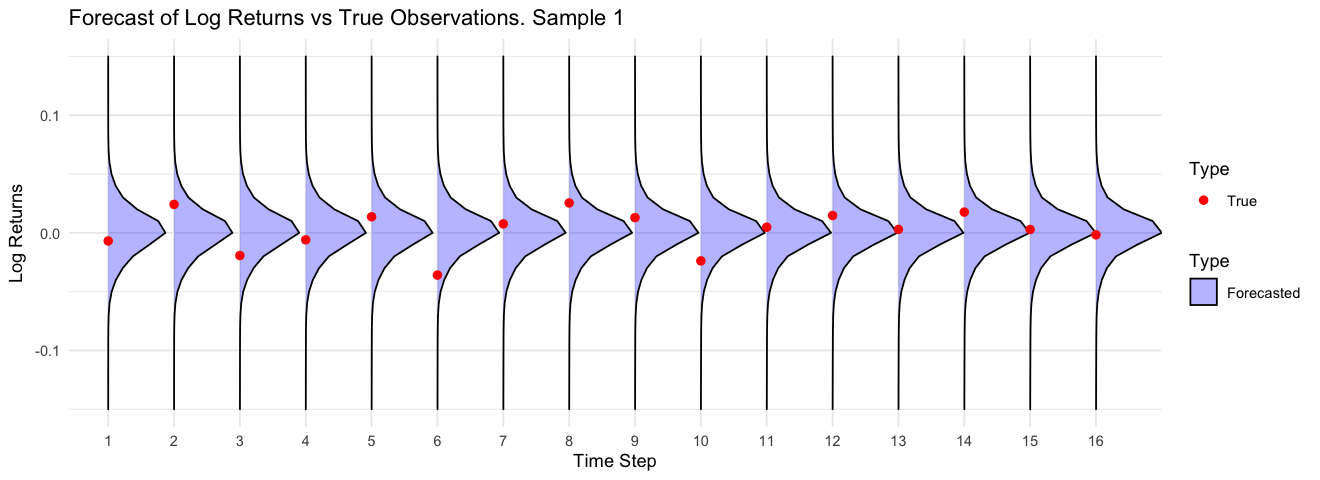

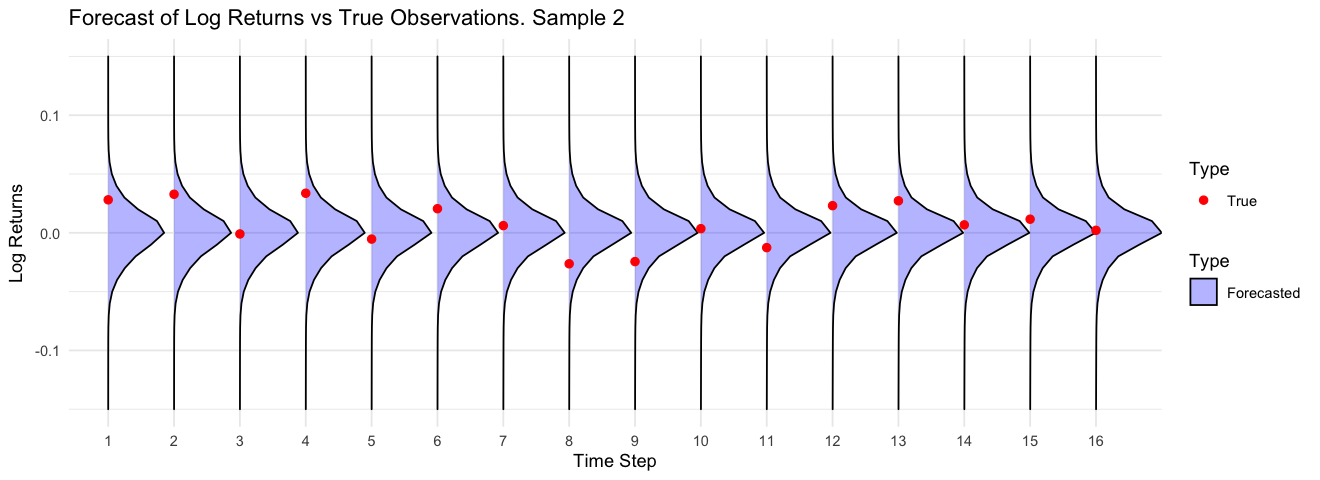

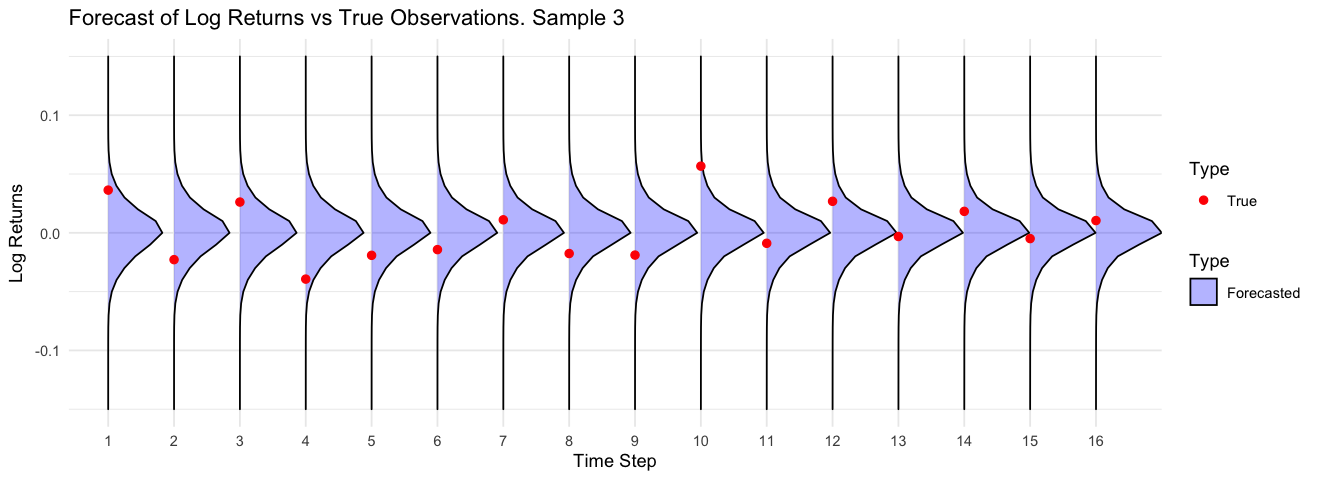

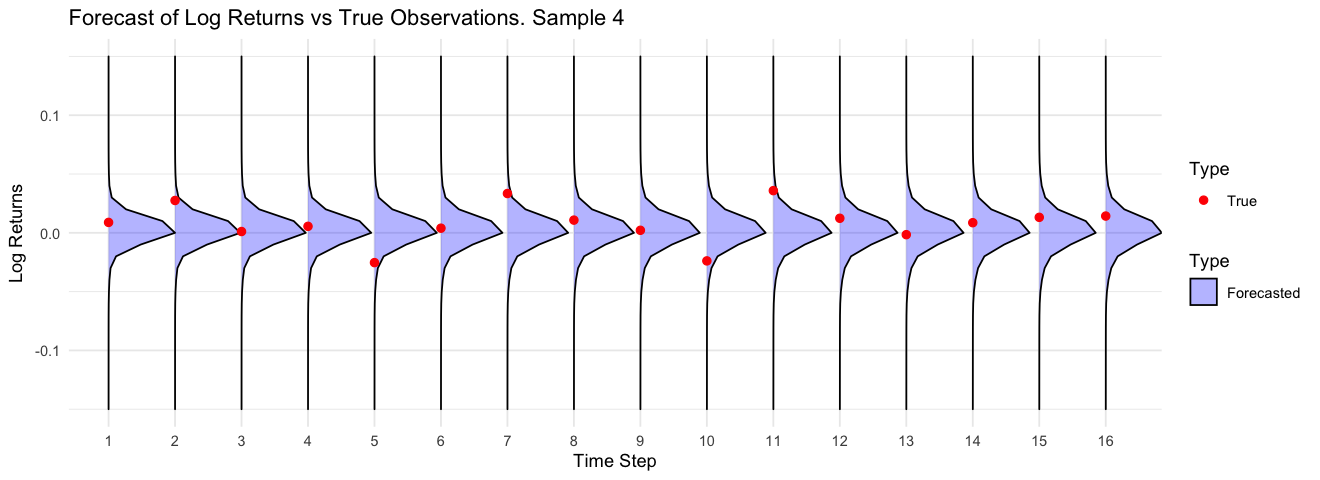

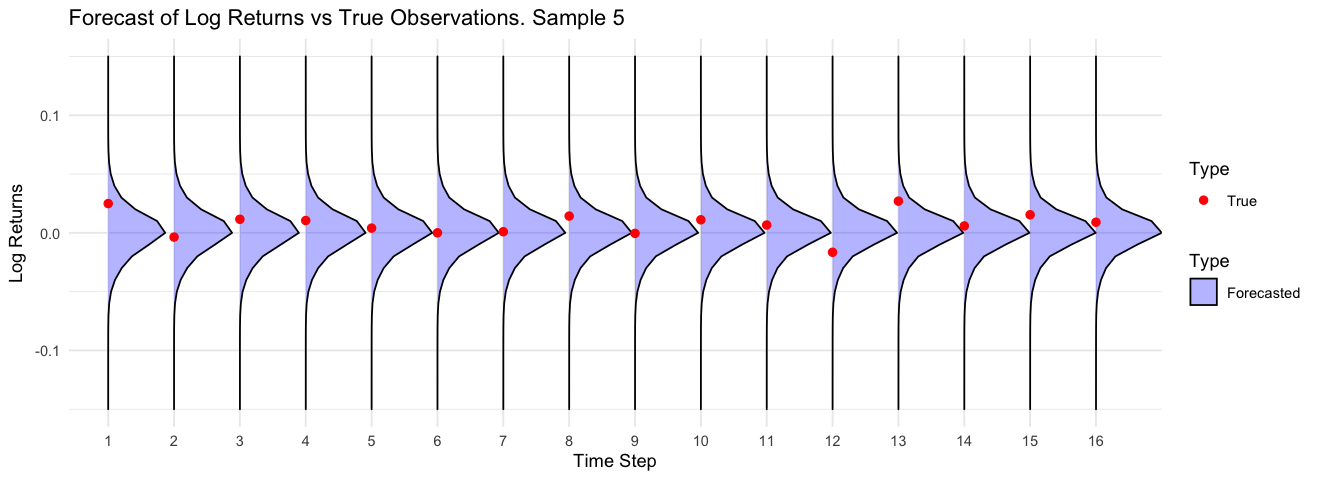

In [14]:
source("markets_functions.R")
for (i in 1:length(splits$train)) {
  plot_ridge_data(
    # Timesteps ahead to be plotted
    forecast_timesteps = seq(1, forecast_range),
    forecast_steps = forecast_steps[[i]],
    forecast_data = forecast_dists_normalized[[i]],
    true_values = test_data_log_list[[i]][[observation]],
    title = paste0("Forecast of Log Returns vs True Observations. Sample ", i),
    y_label = "Log Returns",
    savefig = paste0(plot_folder, "/log_returns_forecast_ridge_plot_sample_", i, ".png")
  )
}



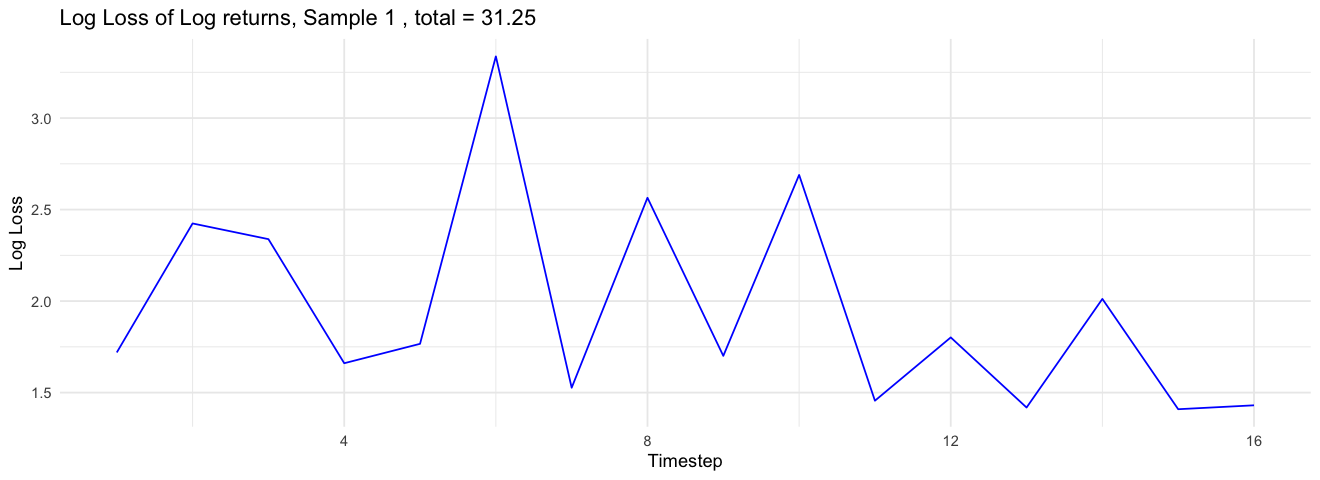

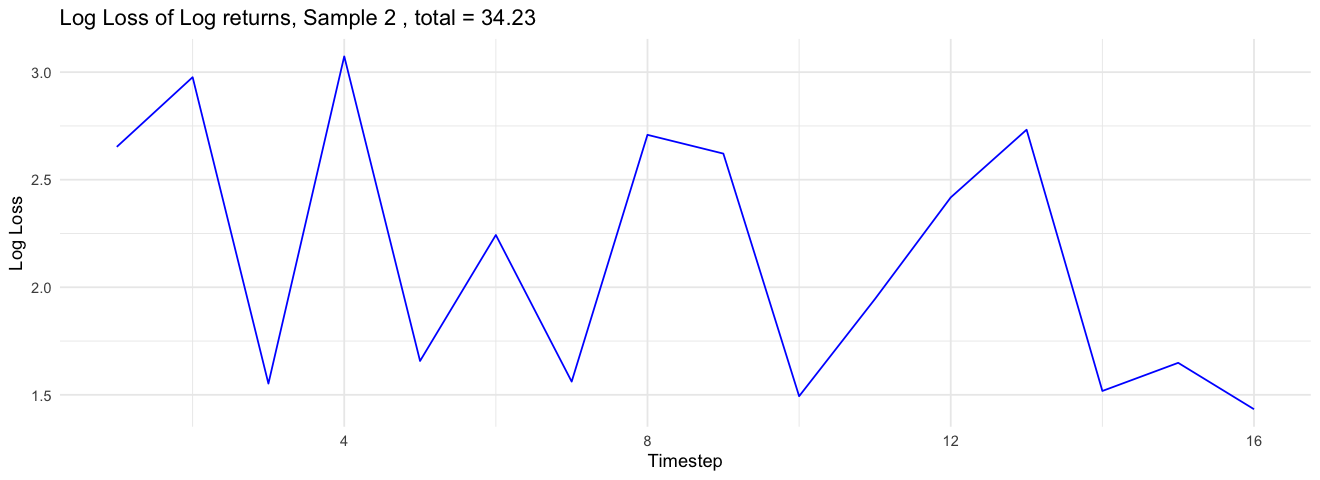

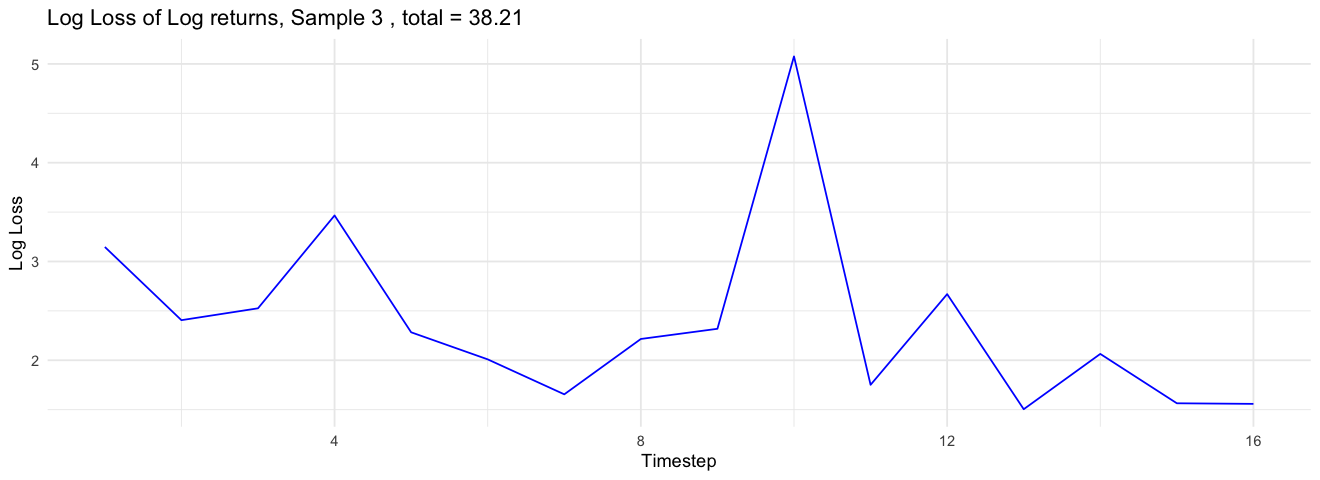

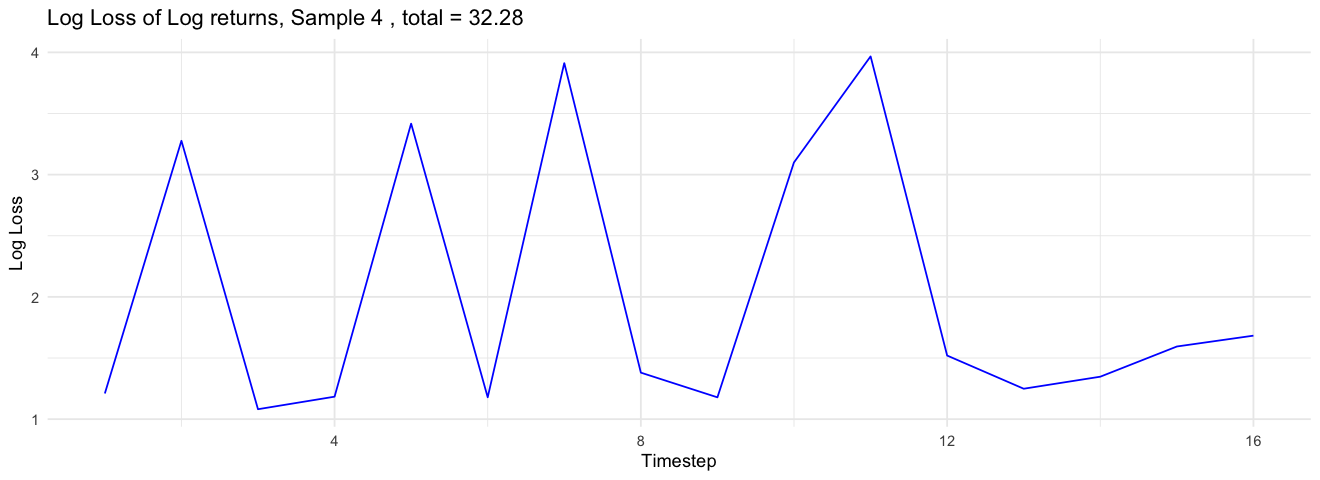

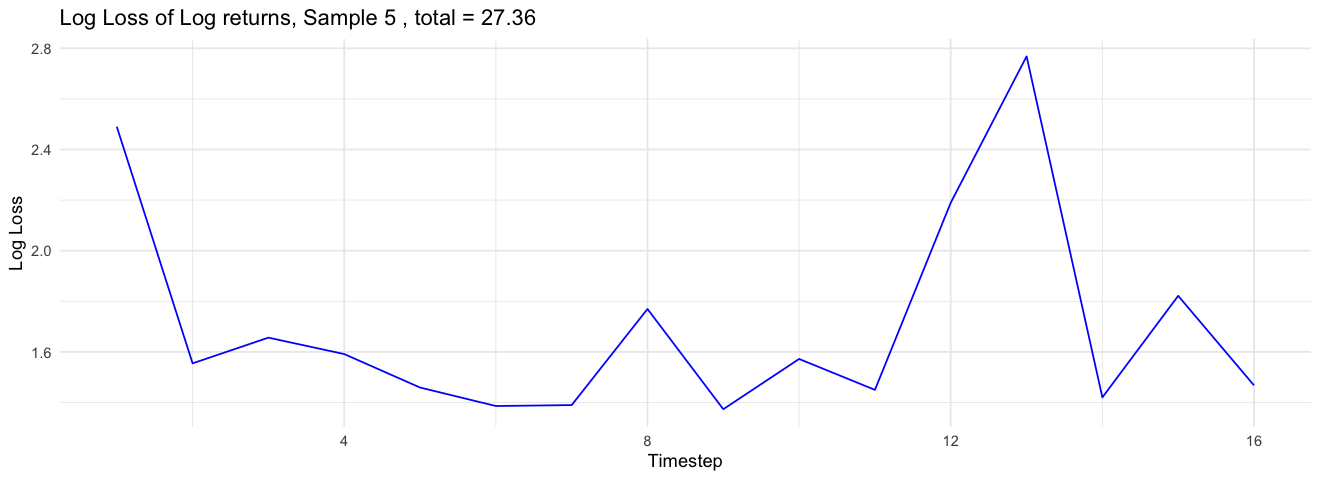

In [15]:
source("markets_functions.R")

for (i in 1:length(splits$train)) {
  plot_log_loss(
    forecast_range,
    forecast_steps[[i]],
    forecast_dists_normalized[[i]],
    test_data_log_list[[i]],
    observation,
    savefig = paste0(plot_folder, "/log_return_log_loss_sample_", i, ".png"),
    title = paste0("Log Loss of Log returns, Sample ", i)
  )
}

In [16]:
compute_real_forecast_probs <- function(forecast_dists_normalized, forecast_steps, forecast_range) {
  length_out <- length(forecast_steps)
  real_forecast_probs <- array(0, dim = dim(forecast_dists_normalized))
  
  first_step_probs <- forecast_dists_normalized[, 1]
  real_forecast_probs[, 1] <- first_step_probs
  current_step_probs <- first_step_probs
  
  for (i in 2:forecast_range) {
    current_step_probs <- convolve(current_step_probs, forecast_dists_normalized[, i], type = "open")
    start <- floor((length(current_step_probs) - length_out) / 2) + 1
    stop <- start + length(first_step_probs) - 1
    real_forecast_probs[, i] <- current_step_probs[start:stop]
  }
  
  return(real_forecast_probs)
}
real_forecast_probs_list <- lapply(1:length(forecasts), function(n) {
  compute_real_forecast_probs(
    forecast_dists_normalized[[n]],
    forecast_steps[[n]],
    forecast_range
  )
})
last_true_values <- sapply(splits$train, function(train_data) {
  tail(train_data[[observation]], 1)
})
real_forecast_steps <- lapply(1:length(forecasts), function(n) {
  last_true_values[[n]] * exp(forecasts[[n]]$eval_range()[[observation]])
})

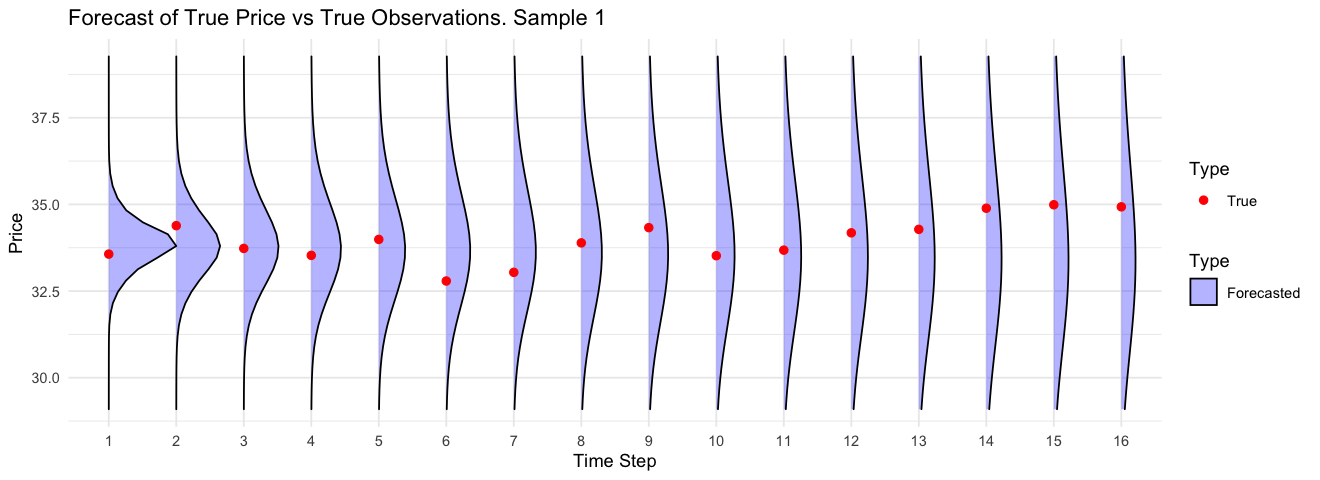

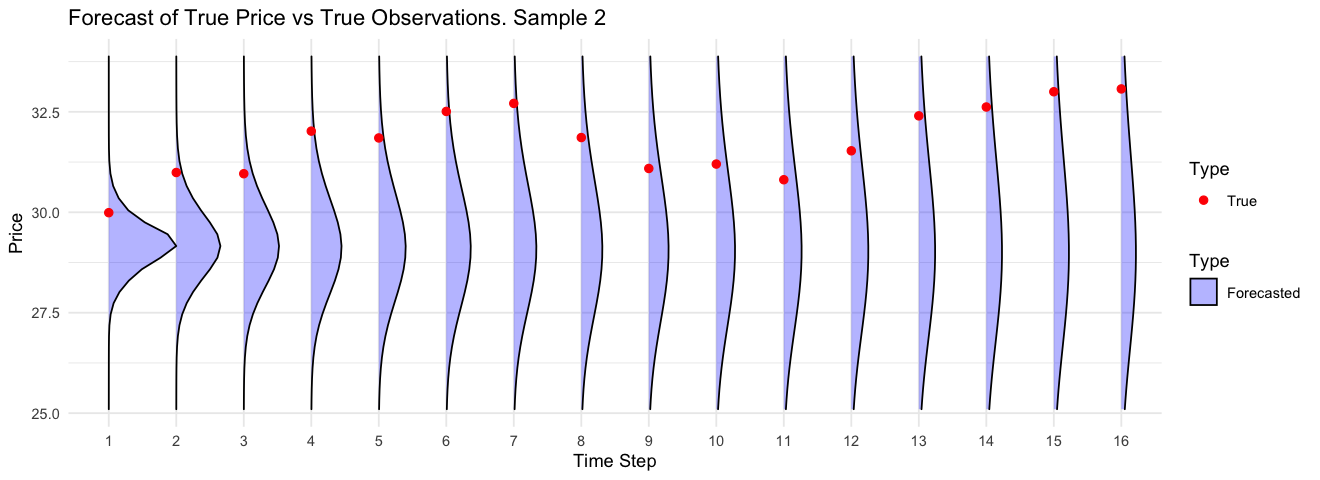

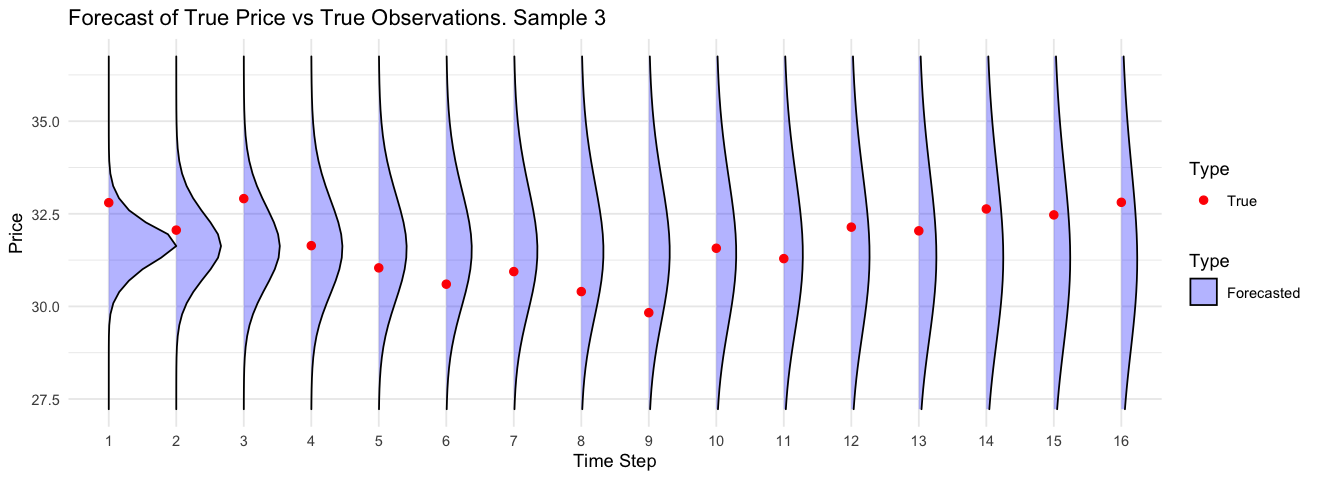

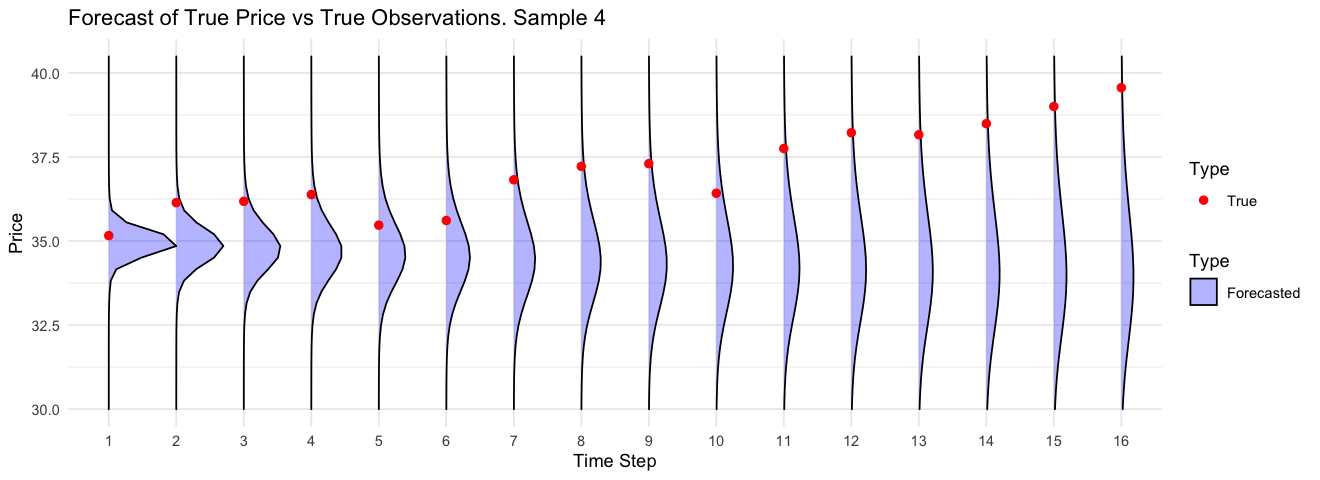

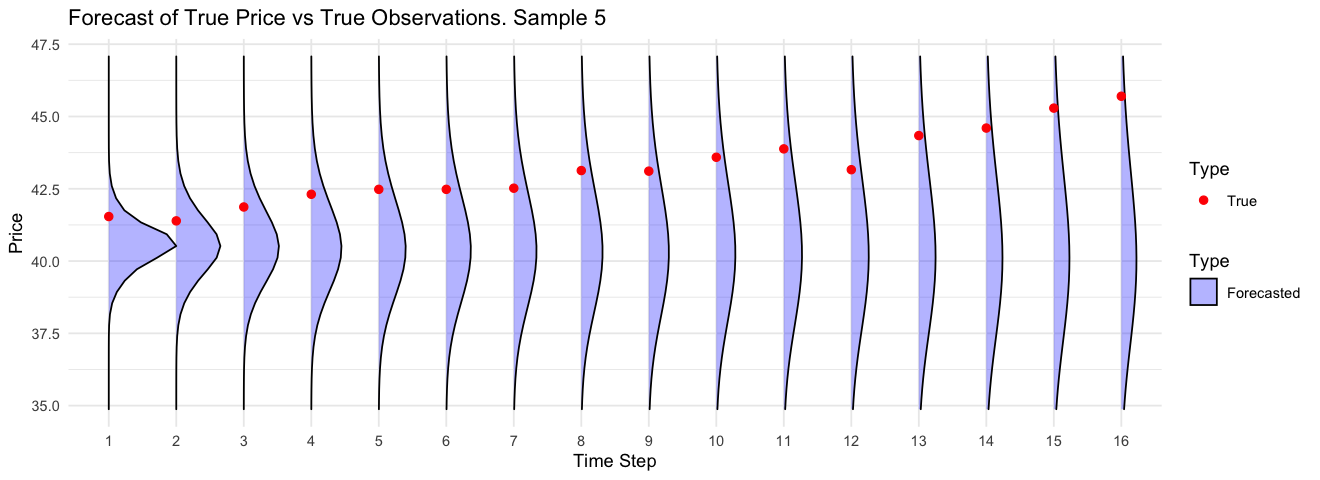

In [17]:
source("markets_functions.R")

# plot ridge plots of real forecasted values
for (i in 1:length(splits$train)) {
  plot_ridge_data(
    # Timesteps ahead to be plotted
    forecast_timesteps = seq(1, forecast_range),
    forecast_steps = real_forecast_steps[[i]],
    forecast_data = real_forecast_probs_list[[i]],
    true_values = splits$test[[i]][[observation]],
    title = paste0("Forecast of True Price vs True Observations. Sample ", i),
    y_label = "Price",
    savefig = paste0(plot_folder, "/true_price_forecast_ridge_plot_sample_", i, ".png")
  )
}

In [ ]:
log_loss <- function(true_values, forecast_dists, eval_range) {
  
  log_loss <- sapply(1:length(true_values[[i]]), function(n) {
    -log(approx(x = eval_range[[i]], y = forecast_dists[[i]][, n], xout = true_values[[i]][n])$y)
  })
  return(loss / length(true_values))  # Return average log loss
}

In [ ]:
plot_log_loss <- function(forecast_range,
                          forecast_steps,
                          forecast_data,
                          true_data,
                          observation,
                          savefig = NULL,
                          title = NULL) {
  log_loss <- sapply(1:forecast_range, function(i) {
    -log(approx(x = forecast_steps, y = forecast_data[, i], xout = true_data[[observation]][i])$y)
  })
  
  options(repr.plot.width = 11, repr.plot.height = 4)  # Adjust figure size
  p <- ggplot(
    data.frame(Timestep = 1:forecast_range, LogLoss = log_loss),
    aes(x = Timestep, y = LogLoss)
  ) +
    geom_line(color = "blue") +
    labs(
      title = if (is.null(title)) {
        paste("Log Loss over Forecast Timesteps, total =", round(sum(log_loss), 2))
      } else {
        paste(title, ", total =", round(sum(log_loss), 2))
      },
      x = "Timestep",
      y = "Log Loss"
    ) +
    theme_minimal()

  device_opened <- open_save_device(
    savefig = savefig,
    width = 1100,
    height = 400
  )

  if (device_opened) {
    print(p)
    grDevices::dev.off()
  }

  print(p)
  invisible(p)
}


[1] 16

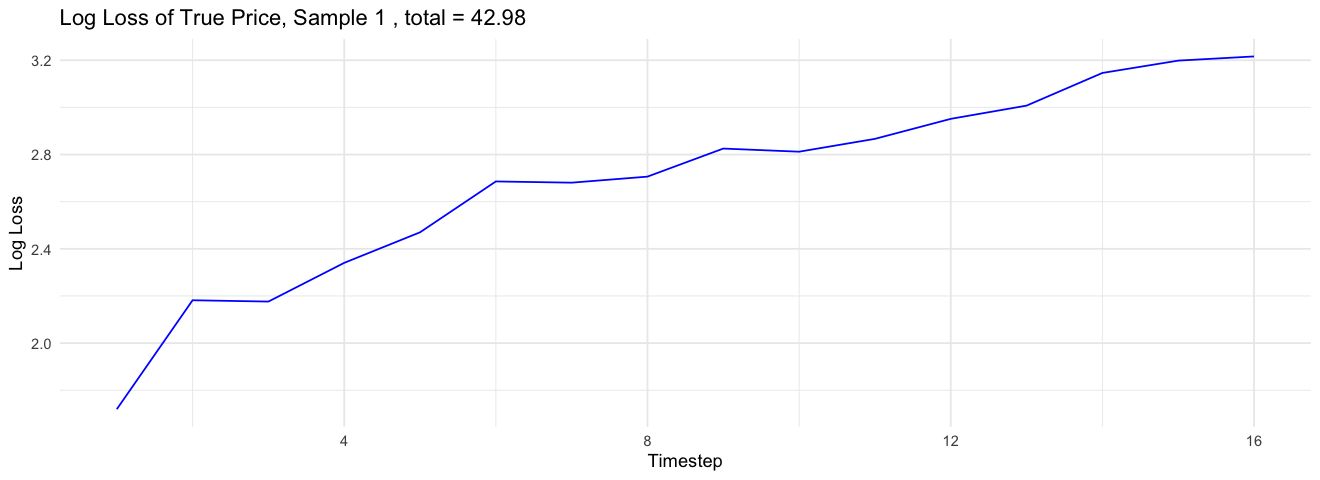

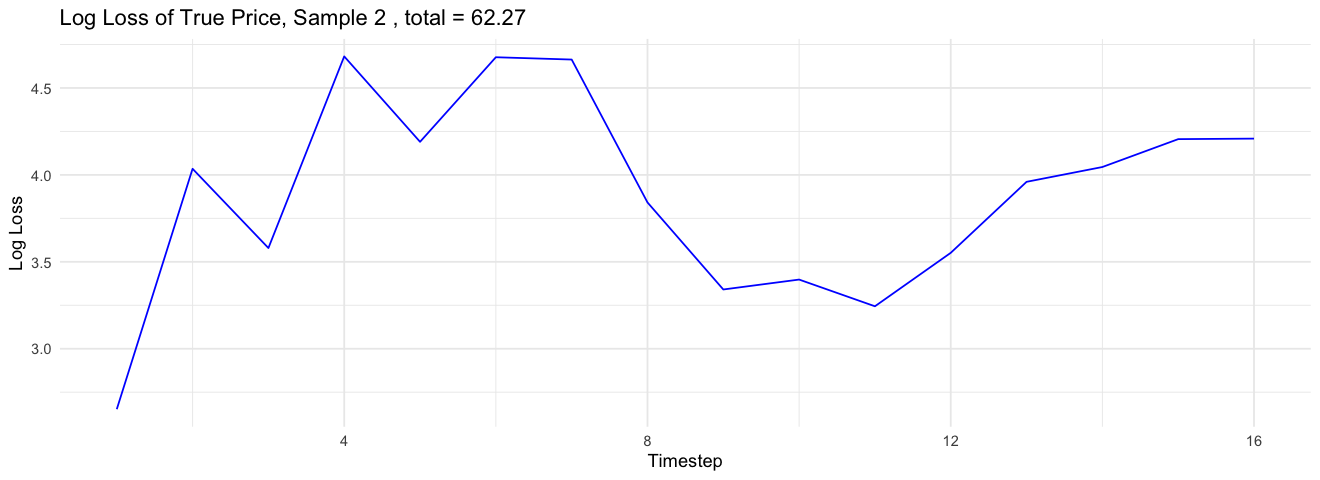

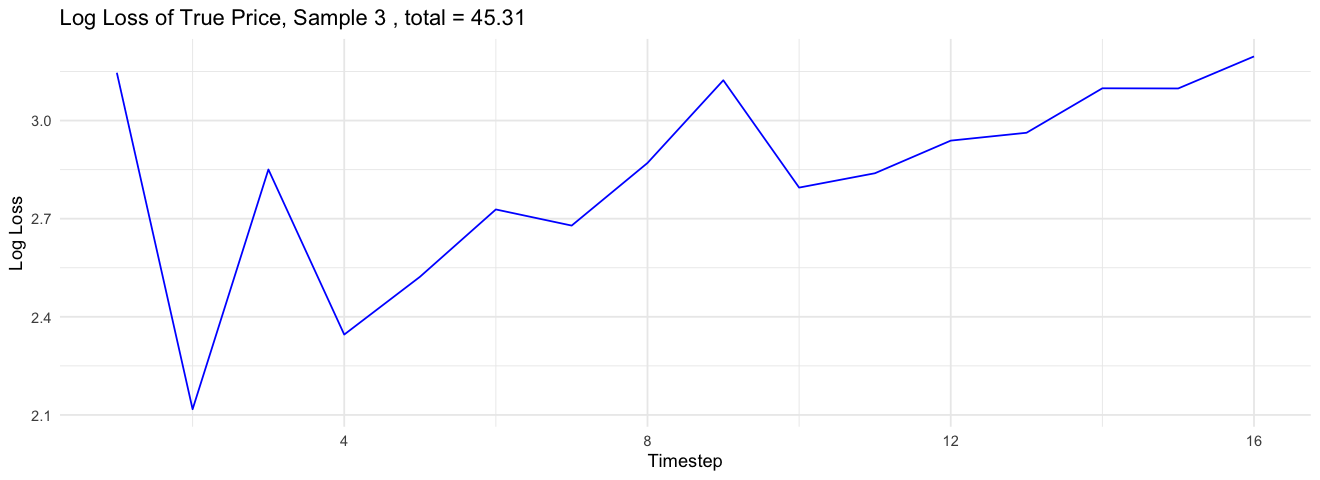

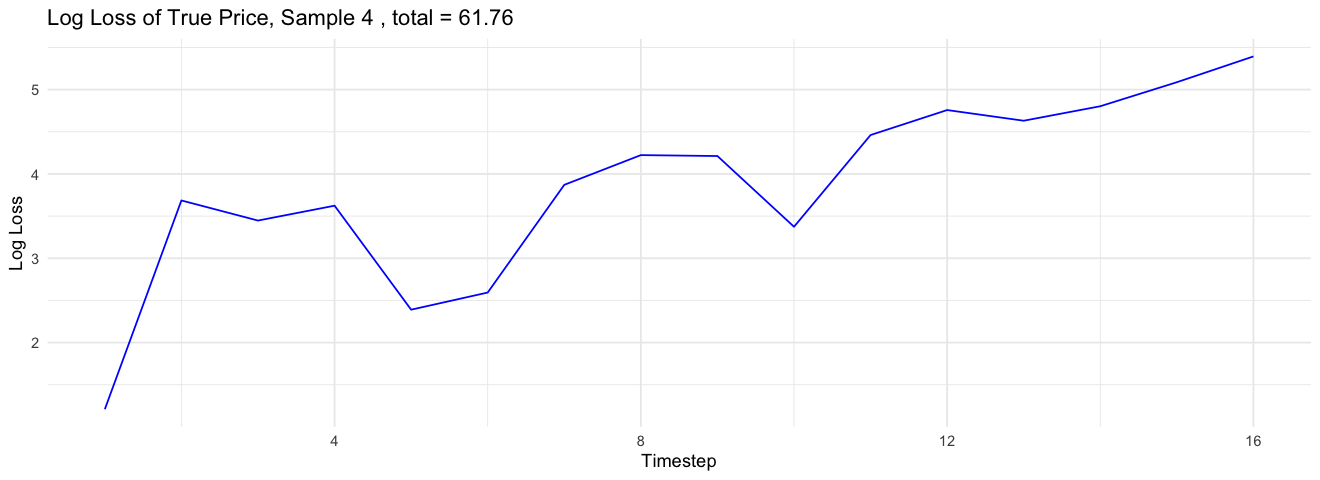

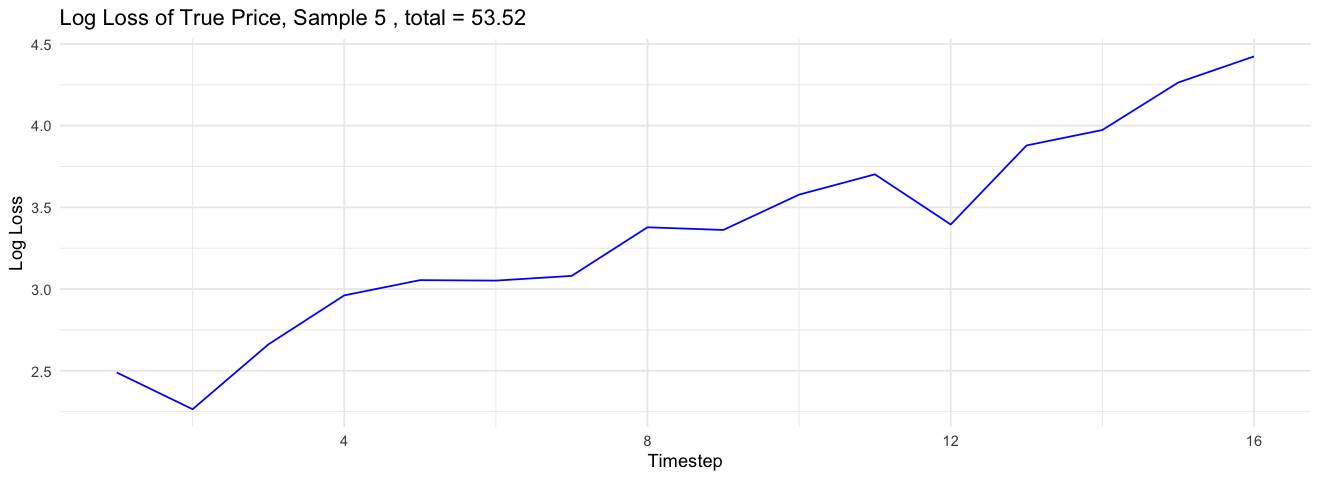

In [18]:
for (i in 1:length(splits$train)) {
  plot_log_loss(
    forecast_range = forecast_range,
    forecast_steps = real_forecast_steps[[i]],
    forecast_data = real_forecast_probs_list[[i]],
    true_data = splits$test[[i]],
    observation = observation,
    savefig = paste0(plot_folder, "/true_price_log_loss_sample_", i, ".png"),
    title = paste0("Log Loss of True Price, Sample ", i)
  )
}